# Dependências

In [2]:
!pip install diffusers transformers accelerate xformers safetensors pillow opencv-python matplotlib pycocotools
!pip install groundingdino-py
!pip install git+https://github.com/facebookresearch/segment-anything.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 13.9 MB/s eta 0:00:00
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88737 sha256=535ee98dad8115c87982cb35d7e21354bcc6f24dd478540b2339191d8432b929
  Stored in directory: /root/.cache/pip/wheels/74/c4/d6/2c6ded61819d391715b4f1ae483f2cfdc8f2eeb6bbb63e748b
Successfully built groundingdino-py
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vy0cbwdi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vy0cbwdi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca50

# Funções auxiliares

## Imagem

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io

def upload_image():
    uploaded = files.upload()
    filename = next(iter(uploaded))
    return Image.open(io.BytesIO(uploaded[filename]))

def save_image(img, path):
    img.save(path)

def show_image(img, title="Image", figsize=(6,6), cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

## Segmentação

In [4]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import numpy as np
import urllib.request

def load_segmentation_model(device="cuda"):
    feature_extractor = SegformerFeatureExtractor.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512"
    )
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512"
    ).to(device)
    model.eval()
    return feature_extractor, model

def get_masks(image: Image.Image, feature_extractor, model, device="cuda"):
    model.to(device)
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False
        )
        masks = torch.argmax(upsampled_logits, dim=1)[0].cpu().numpy()
    num_classes = logits.shape[1]
    class_masks = {}
    for cls in range(num_classes):
        class_masks[cls] = (masks == cls).astype(np.uint8) * 255
    return class_masks

def get_classes():
    url = "https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.txt"
    response = urllib.request.urlopen(url)
    lines = [line.decode("utf-8").strip() for line in response.readlines()]
    class_idx_to_name = {}
    for line in lines:
        if not line or line.startswith("Idx"):
            continue
        parts = line.split("\t")
        if len(parts) < 5:
            continue
        idx = int(parts[0])
        name = parts[4].strip()
        class_idx_to_name[idx] = name
    return class_idx_to_name

def get_mask_for_class_idx(class_masks, class_idx):
    if class_idx not in class_masks:
        return None
    return Image.fromarray(class_masks[class_idx])



## Texto

In [5]:
import re

STOPWORDS = {"the", "a", "an", "in", "on", "for", "to", "of", "and", "is", "with", "at", "from", "by"}

def extract_class_from_prompt(prompt, classes):
    prompt = prompt.lower()
    words = re.findall(r'\w+', prompt)
    keywords = [w for w in words if w not in STOPWORDS]

    for word in keywords:
        for idx, name in classes.items():
            class_words = [n.strip() for n in name.lower().split(",")]
            if word in class_words:
                return idx - 1
    return None

In [6]:
import re

def extract_target_result(prompt: str):
    """
    Extrai (target, result) de prompts tipo turn/change/replace/convert/transform
    incluindo flexões verbais e verbo em qualquer posição da frase.
    """
    # padrões gerais: verbo (flexionado) + preposição + resultado
    verbs = ["turn", "change", "replace", "convert", "transform"]
    preps = ["into", "for", "with"]

    # construir regex dinâmico
    verb_pattern = "|".join([v + r"(?:ed|ing)?" for v in verbs])  # turn, turned, turning
    prep_pattern = "|".join(preps)

    pattern = rf".*?\b({verb_pattern})\b (?:the )?(.+?)\b({prep_pattern})\b (.+)"

    match = re.match(pattern, prompt, re.IGNORECASE)
    if match:
        target = match.group(2).strip()
        result = match.group(4).strip()
        return (target, result)

    return None

# Teste
prompts = [
    "turn the mountain into a volcanic mountain",
    "change the sky for midnight sky",
    "replace the road with grassy meadow, flowers, natural path",
    "the road turned into a river and lake water",
    "transform the river and bridge into molten lava and obsidian structures"
]

for p in prompts:
    print(p, "→", extract_target_result(p))


turn the mountain into a volcanic mountain → ('mountain', 'a volcanic mountain')
change the sky for midnight sky → ('sky', 'midnight sky')
replace the road with grassy meadow, flowers, natural path → ('road', 'grassy meadow, flowers, natural path')
the road turned into a river and lake water → None
transform the river and bridge into molten lava and obsidian structures → ('river and bridge', 'molten lava and obsidian structures')


## Textual refinement

In [7]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image

def load_model(
    model_name="runwayml/stable-diffusion-inpainting",
    dtype=torch.float16,
    device="cuda"
):
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_name,
        torch_dtype=dtype,
        safety_checker=None
    )
    pipe = pipe.to(device)
    pipe.enable_attention_slicing()
    pipe.enable_xformers_memory_efficient_attention()
    return pipe

def refine_image(pipe, image, mask, prompt, negative="", strength=0.8, guidance=7.5):
    out = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=image,
        mask_image=mask,
        strength=strength,
        guidance_scale=guidance
    ).images[0]
    return out


# Pipeline

Saving horse2.jpg to horse2 (3).jpg
grass
meadow completely covered by colorful flowers


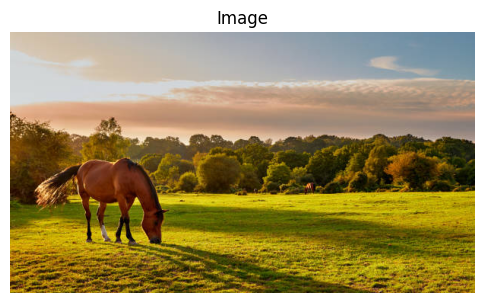

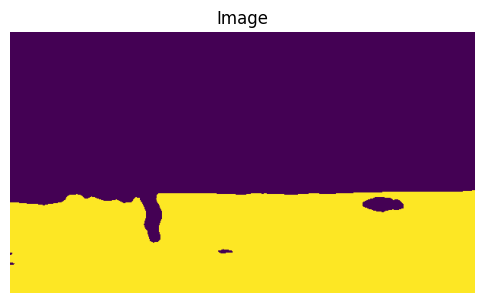

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

  0%|          | 0/37 [00:00<?, ?it/s]

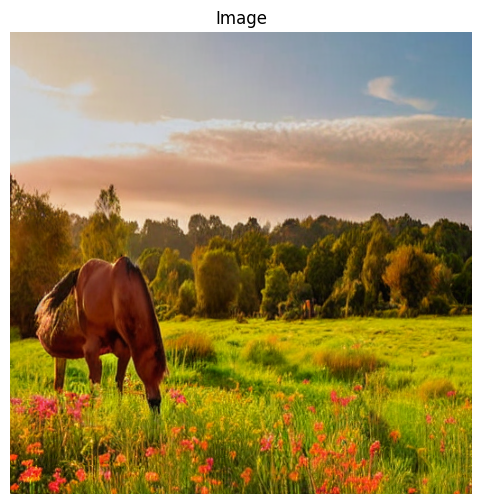

In [13]:
DISPLAY_IMAGES = True

image = upload_image()

prompt = "replace the grass with meadow completely covered by colorful flowers"

source, target = extract_target_result(prompt)

print(source)
print(target)

if DISPLAY_IMAGES:
  show_image(image)

# 1. obtém máscara com modelo de segemntação
classes = get_classes()

segmentation_class = extract_class_from_prompt(prompt, classes)

feature_extractor, model = load_segmentation_model()

class_masks = get_masks(image, feature_extractor, model)

# for key in class_masks:
#   if np.any(class_masks[key]):
#     print(key)
#     show_image(Image.fromarray(class_masks[key]))

mask = get_mask_for_class_idx(class_masks, segmentation_class)

if DISPLAY_IMAGES:
  show_image(mask)

# 2. textual refinement

pipe = load_model()

refined_image = refine_image(
    pipe=pipe,
    image=image,
    mask=mask,
    prompt=target,
    negative="",
    strength=0.75,
    guidance=13
)

if DISPLAY_IMAGES:
  show_image(refined_image)